!Go directly to:
- [**Start page**](https://github.com/m-guggenmos/remeta_v1/)
- [**Installation**](https://github.com/m-guggenmos/remeta_v1/blob/main/INSTALL.md)
- [**Basic Usage**](https://github.com/m-guggenmos/remeta_v1/blob/main/demo/basic_usage.ipynb)
- [**Common use cases** (this page)](https://github.com/m-guggenmos/remeta_v1/blob/main/demo/common_use_cases.ipynb)

## Common use cases

This page introduces some common use cases for the _ReMeta_ toolbox.


[Use case 1: Fit type 1 level only](#Use-case-1:-Fit-type-1-level-only)

[Use case 2: Model with a single metacognitive bias parameter](#Use-case-2:-Model-with-a-single-metacognitive-bias-parameter)

[Use case 3: Noisy-readout model](#Use-case-3:-Noisy-readout-model)

In a first step we import the remeta module

In [1]:
import remeta_v1.remeta as remeta

<a id='uc1'></a>

### Use case 1: Fit type 1 level only
With the remeta.load_dataset() method we have access to a couple of simulated datasets. The first dataset is called 'type1_only'.

In [2]:
x_stim, d_dec, c_conf, params = remeta.load_dataset('type1_only', return_params=True)

Loading dataset 'type1_only' which was generated as follows:
..Generative model:
    Type 2 noise type: noisy_report
    Type 2 noise distribution: beta
..Generative parameters:
    type1_noise: 0.7
    type1_bias: 0.2
..Characteristics:
    No. subjects: 1
    No. samples: 2000
    Type 1 performance: 80.2%


We expect a psychometric curve that is shifted towards a preference for $S^+$ due to the positive type 1 bias:

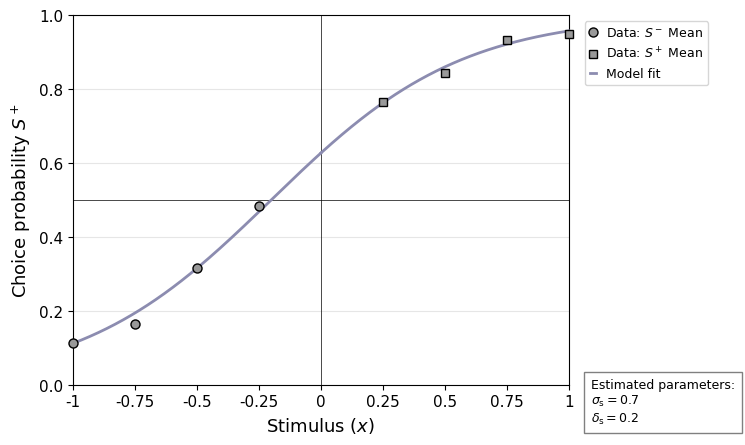

In [3]:
remeta.plot_psychometric(d_dec, x_stim, params);

Since this dataset includes no confidence ratings, we use `fit_type1()` instead of `fit()`:

In [4]:
cfg = remeta.Configuration()
cfg.true_params = params  # allows comparison with true generative parameters
rem = remeta.ReMeta(cfg=cfg)
rem.fit_type1(x_stim, d_dec)


+++ Type 1 level +++
Initial guess (neg. LL: 973.89)
    [guess] type1_noise: 0.5
    [guess] type1_bias: 0
Performing local optimization
    [final] type1_noise: 0.696 (true: 0.7)
    [final] type1_bias: 0.191 (true: 0.2)
Final neg. LL: 887.90
Neg. LL using true params: 887.97
Total fitting time: 0.11 secs


The `summary()` method of the remeta instance returns a result object that contains, among others, information about inferred parameters and model evidence:

In [5]:
# Access results throught the summary method:
result = rem.summary()
# Individual parameters:
for k, v in result.model.params_type1.items():
    print(f'{k}: {v:.3f}')
# Negative log likelihood:
print(f"Neg. LL: {result.model.type1_model_evidence['negll']:.2f}")
# Akaike Information Criterion (AIC):
print(f"AIC: {result.model.type1_model_evidence['aic']:.2f}")
# Bayesian Information Criterion (BIC):
print(f"BIC: {result.model.type1_model_evidence['bic']:.2f}")

type1_noise: 0.696
type1_bias: 0.191
Neg. LL: 887.90
AIC: 1779.79
BIC: 1791.00


<a id='uc2'></a>

### Use case 2: Model with a single metacognitive bias parameter
By default, ReMeta uses confidence criteria to handle any biases relative to an optimal Bayesian confidence observer. In addition, in ReMeta it is possible to assume that metacognitive biases can be described by
 a single multiplicative metacognitive bias parameter. This corresponds essentially to a metacognitive "gain" parameter which scales evidence proportionally. The advantage is a clear interpretation, since a multiplicative bias < 1 or > 1 corresponds to under- and overconfidence, respectively.

We load data that were generated with such a model:

In [6]:
x_stim, d_dec, c_conf, params, y_decval = remeta.load_dataset(
    'type2_multiplicative_bias', return_params=True, return_y_decval=True
)

Loading dataset 'type2_multiplicative_bias' which was generated as follows:
..Generative model:
    Type 2 noise type: noisy_report
    Type 2 noise distribution: beta
..Generative parameters:
    type1_noise: 0.6
    type1_bias: 0
    type2_noise: 7
    type2_evidence_bias_mult: 0.8
..Characteristics:
    No. subjects: 1
    No. samples: 2000
    Type 1 performance: 83.9%
    Avg. confidence: 0.589
    M-Ratio: 0.762


Due to the fact that `type2_evidence_bias_mult` is smaller than 1, we have generated data for an underconfident observer.

To fit such a generated datset we define a model for which we 1) disable the fitting of criteria, 2) enable a multiplicative bias parameter and 3) change the type 2 fitting type to "continuous". The latter is not strictly necessary, but would be more precise if the confidence ratings are indeed generated from a continuous process.

In [7]:
cfg = remeta.Configuration()
cfg.type2_fitting_type = 'continuous'
cfg.enable_type2_param_criteria = 0
cfg.enable_type2_param_evidence_bias_mult = 1
cfg.true_params = params
rem = remeta.ReMeta(cfg)
rem.fit(x_stim, d_dec, c_conf)


+++ Type 1 level +++
Initial guess (neg. LL: 801.58)
    [guess] type1_noise: 0.5
    [guess] type1_bias: 0
Performing local optimization
    [final] type1_noise: 0.593 (true: 0.6)
    [final] type1_bias: -0.00134 (true: 0)
Final neg. LL: 791.41
Neg. LL using true params: 791.46
Total fitting time: 0.074 secs

+++ Type 2 level +++
Initial guess (neg. LL: 8615.02)
    [guess] type2_noise: 8.863
    [guess] type2_evidence_bias_mult: 1
Performing local optimization
    [final] type2_noise: 7.28 (true: 7)
    [final] type2_evidence_bias_mult: 0.797 (true: 0.8)
Final neg. LL: 8324.80
Neg. LL using true params: 8343.99
Total fitting time: 2.1 secs


Let's take a look at the relationship between type 1 decision values and confidence:

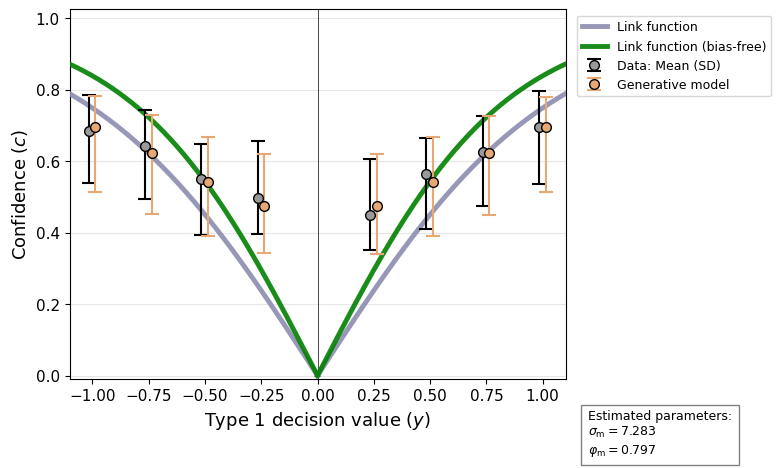

In [8]:
rem.plot_evidence_versus_confidence(plot_bias_free=True)

Since the fitted parameters recovered the generative parameters quite well, predicted and empirical (here: generated) confidence ratings look very similar.


The green line reflects the conversion of type 1 decision values to confidence by the modeled observer, whereas the purple line reflects a Bayes-optimal confidence observer. In comparison, we recognize the underconfidence of the modeled observer.

The term "link function" is used here to describe the transformation from type 1 decision values (or type 1 evidence) to confidence. In all cases this transformation assumes that observers _aim_ at computing probability correct like a Bayesian confidence observer. This aim can be compromised in two ways: through biases (which are reflected in the plotted "link function") and noise. The effect of noise causes the difference between the purple line and the data (empirical or generated).


As for the type 1 level, the summary() method of the _ReMeta_ instance gives access to the parameters and the model evidence of the type 2 level:

In [9]:
# Access results throught the summary method:
result = rem.summary()
# Individual parameters:
for k, v in result.model.params_type2.items():
    print(f'{k}: {v:.3f}')
# Negative log likelihood:
print(f"Neg. LL: {result.model.type2_model_evidence['negll']:.2f}")
# Akaike Information Criterion (AIC):
print(f"AIC: {result.model.type2_model_evidence['aic']:.2f}")
# Bayesian Information Criterion (BIC):
print(f"BIC: {result.model.type2_model_evidence['bic']:.2f}")

type2_noise: 7.283
type2_evidence_bias_mult: 0.797
Neg. LL: 8324.80
AIC: 16653.60
BIC: 16664.80


### Use case 3: Noisy-readout model
Researchers might have the hypothesis that metacognitive inefficiencies predominate at the level of the readout, e.g. because a theory about a psychiatric condition predicts more noisy metacognitive processing earlier in the metacognitive processing hierarchy. In this case, the data can be fit in noisy-readout mode by setting `type2_noise_type` from `'noisy_report'` to `'noisy_readout'`, reflecting the assumption that metacognitive noise most dominantely arises at the level of type 1 decision value readout and not during communication or report.

In [10]:
x_stim, d_dec, c_conf, params, y_decval = remeta.load_dataset(
    'noisy_readout', return_params=True, return_y_decval=True
)

Loading dataset 'noisy_readout' which was generated as follows:
..Generative model:
    Type 2 noise type: noisy_readout
    Type 2 noise distribution: gamma
..Generative parameters:
    type1_noise: 0.4
    type1_bias: 0
    type2_noise: 7
    type2_criteria: [0.3, 0.4, 0.1, 0.1] = gaps | criteria = [0.3, 0.7, 0.8, 0.9]
..Characteristics:
    No. subjects: 1
    No. samples: 2000
    Type 1 performance: 91.6%
    Avg. confidence: 0.670
    M-Ratio: 0.762
    Criterion bias: 0.125


Here we have a simulated observer with high type 1 performance (90% correct responses) but severe underconfidence. The underconfidence is reflected in relatively high confidence criteria which would require a high level of internal confidence before the observer indicates high confidence to the external world. This is reflected in a plot that relates evidence to confidence:

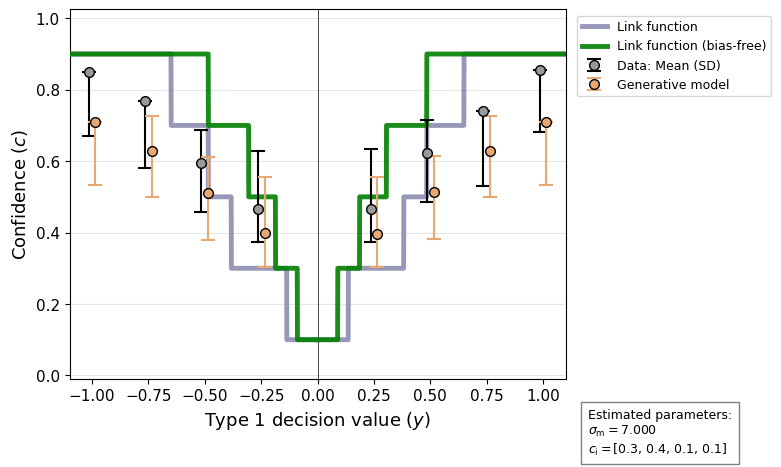

In [11]:
remeta.plot_evidence_versus_confidence(x_stim, c_conf, y_decval, params, plot_bias_free=True);

The green line reflects the conversion of type 1 decision values to confidence by the simulated observer with (four) suboptimal confidence criteria. The purple line represents a Bayes-optimal observer with likewise four confidence criteria. The difference between both lines showcases that the simulated observer needs more evidence to arrive at a given confidence rating.

To model this scenario, we set `type2_noise_type` to `'noisy_readout'`.

In [12]:
cfg = remeta.Configuration()
cfg.type2_noise_type = 'noisy_readout'
cfg.true_params = params
rem = remeta.ReMeta(cfg)

In [13]:
rem.fit(x_stim, d_dec, c_conf)


+++ Type 1 level +++
Initial guess (neg. LL: 505.03)
    [guess] type1_noise: 0.5
    [guess] type1_bias: 0
Performing local optimization
    [final] type1_noise: 0.363 (true: 0.4)
    [final] type1_bias: -0.0235 (true: 0)
Final neg. LL: 475.70
Neg. LL using true params: 479.22
Total fitting time: 0.11 secs

+++ Type 2 level +++
Initial guess (neg. LL: 6263.89)
    [guess] type2_noise: 8.952
    [guess] type2_criteria_0: 0.2
    [guess] type2_criteria_1: 0.2 = gap | criterion = 0.4
    [guess] type2_criteria_2: 0.2 = gap | criterion = 0.6
    [guess] type2_criteria_3: 0.2 = gap | criterion = 0.8
Performing local optimization
    [final] type2_noise: 7.17 (true: 7)
    [final] type2_criteria_0: 0.349 (true: 0.3)
    [final] type2_criteria_1: 0.395 (true: 0.4) = gap | criterion = 0.744 (true: 0.7)
    [final] type2_criteria_2: 0.102 (true: 0.1) = gap | criterion = 0.846 (true: 0.8)
    [final] type2_criteria_3: 0.0801 (true: 0.1) = gap | criterion = 0.926 (true: 0.9)
    [extra] type2_c